In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 200

ng =11

ng_refs = (/ 2 , 3 , 6 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 340

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66/

data wgt
     &     /0.5 , 0.5 , 0.5 , 0.5,
     &     0.5 , 0.5 , 0.7 , 0.7,
     &     0.7 , 0.7 , 0.7/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

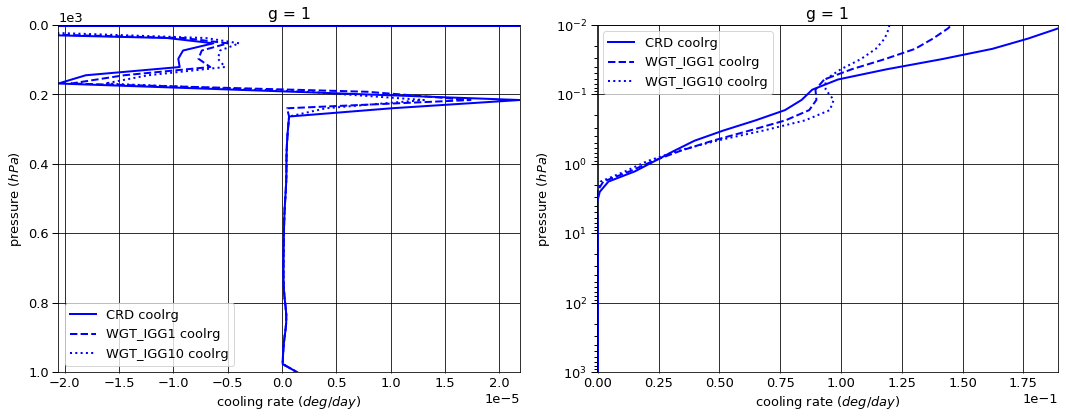

# Figure: cooling rate g-group 2

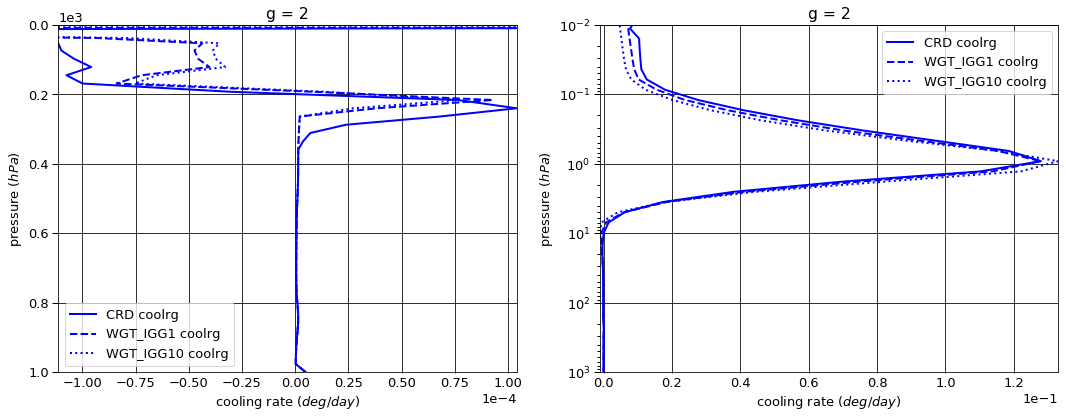

# Figure: cooling rate g-group 3

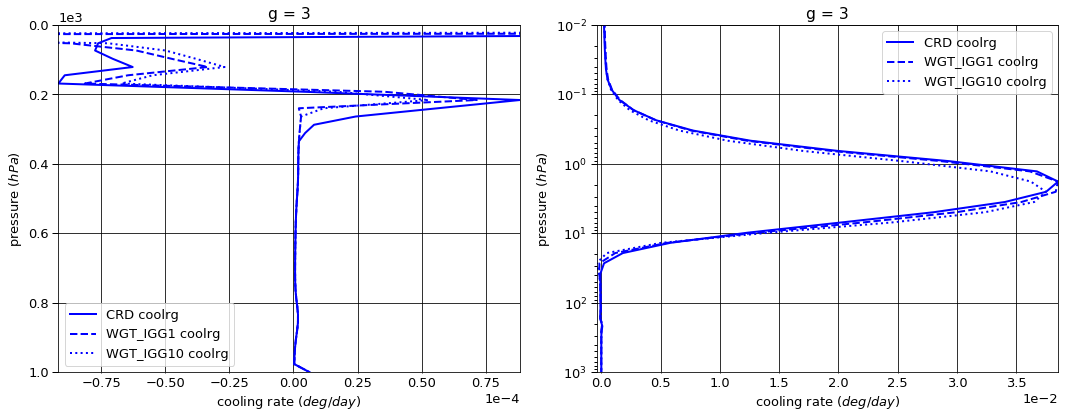

# Figure: cooling rate g-group 4

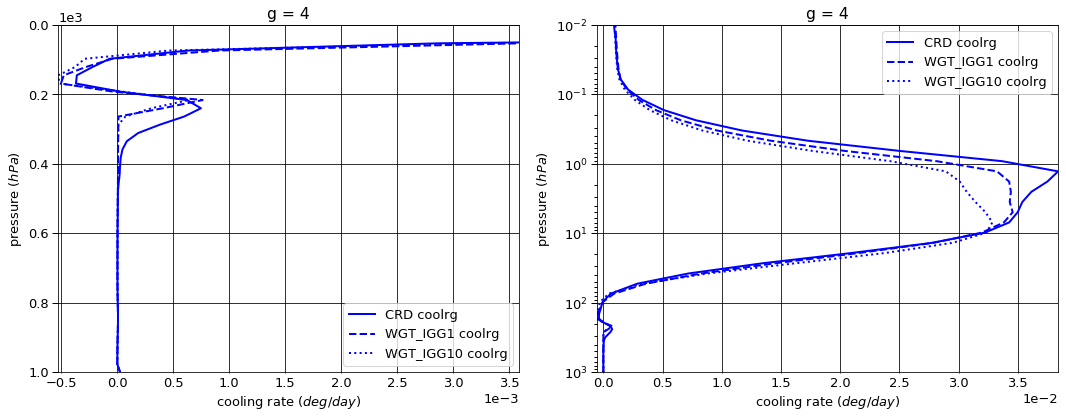

# Figure: cooling rate g-group 5

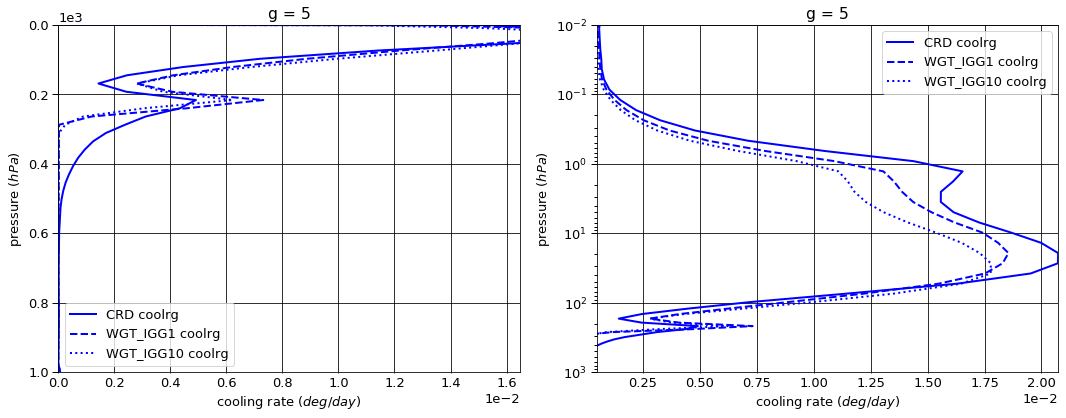

# Figure: cooling rate g-group 6

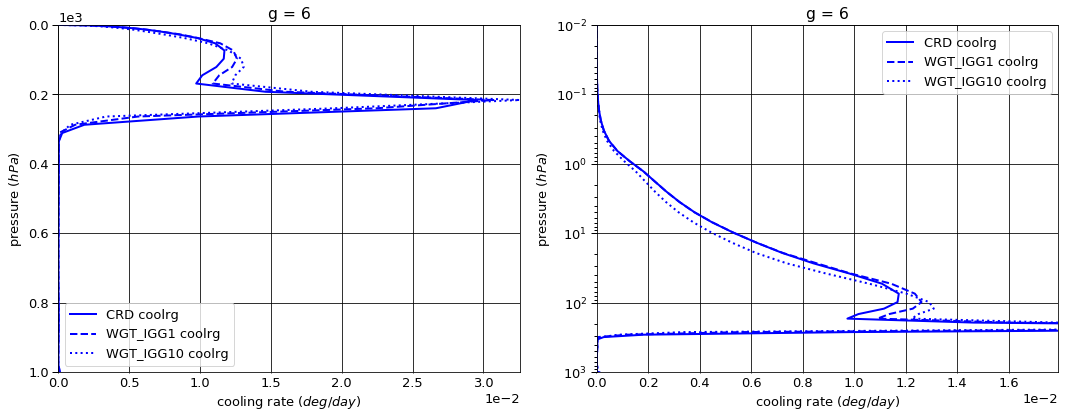

# Figure: cooling rate g-group 7

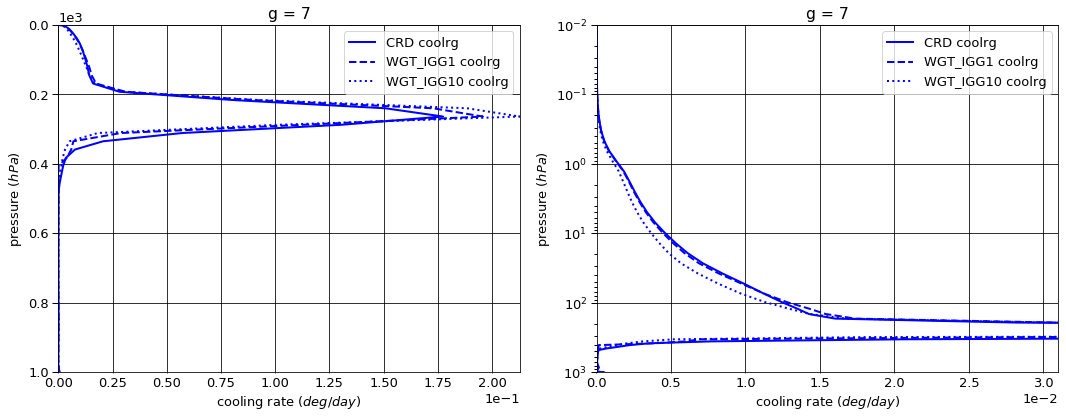

# Figure: cooling rate g-group 8

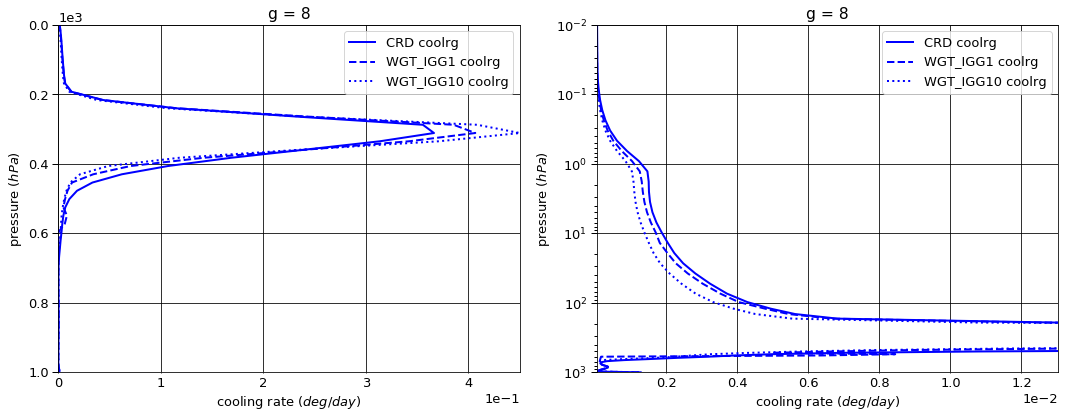

# Figure: cooling rate g-group 9

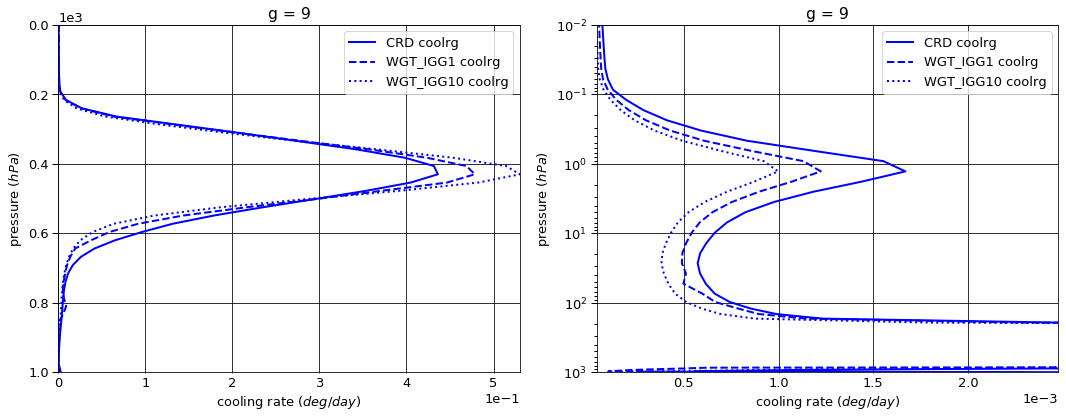

# Figure: cooling rate g-group 10

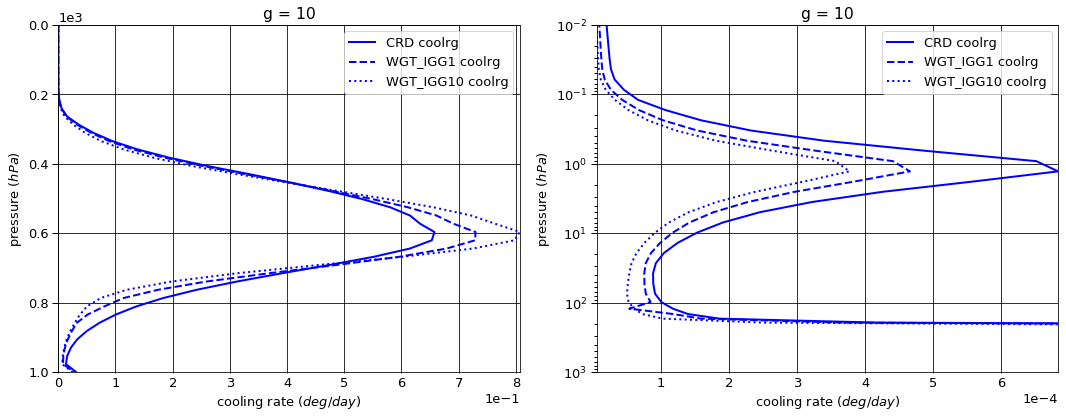

# Figure: cooling rate g-group 11

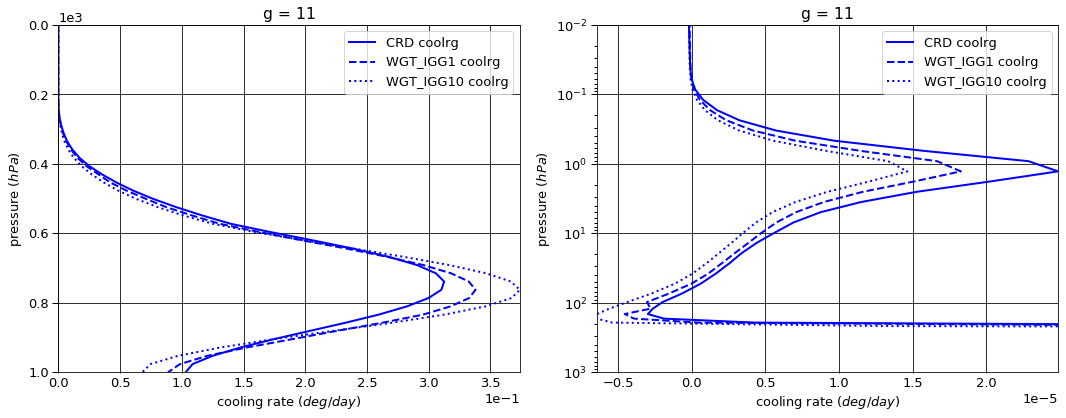

# Figure: cooling rate g-group total

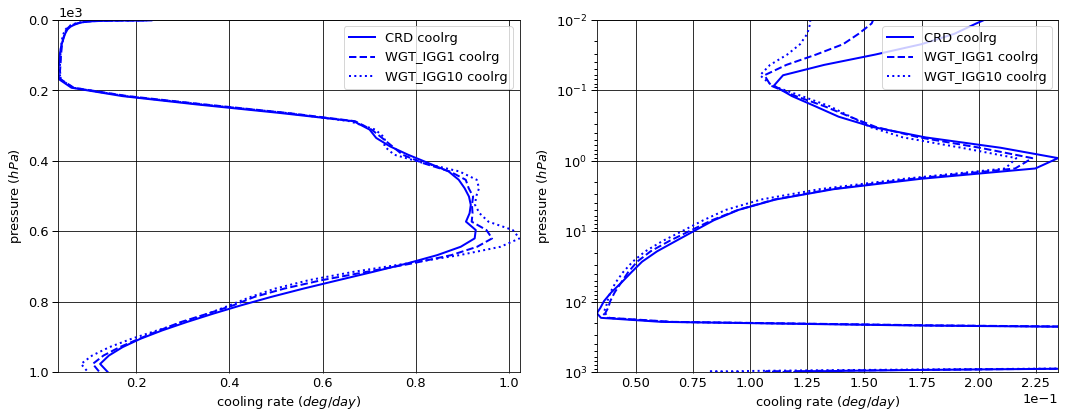

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006920   0.000000  -0.006920
   1013.0   76     -0.011469   0.011465  -0.000004
2  0.0      1      -0.028434   0.000000  -0.028434
   1013.0   76     -0.038221   0.038207  -0.000014
3  0.0      1      -0.035212   0.000000  -0.035212
   1013.0   76     -0.052199   0.052182  -0.000017
4  0.0      1      -0.114174   0.000000  -0.114174
   1013.0   76     -0.204942   0.204869  -0.000072
5  0.0      1      -0.277855   0.000000  -0.277855
   1013.0   76     -0.555325   0.555130  -0.000195
6  0.0      1      -0.449898   0.000000  -0.449898
   1013.0   76     -0.903294   0.902989  -0.000305
7  0.0      1      -2.111788   0.000000  -2.111788
   1013.0   76     -3.982269   3.980871  -0.001398
8  0.0      1      -6.033522   0.000000  -6.033522
   1013.0   76    -10.076173  10.072649  -0.003524
9  0.0      1     -11.956856   0.000000 -11.956856
   1013.0   76    -17.587622  17.580169  -0.007454
10 0.0      1     -25.270247   0.000000 -25.270247
   1013.0   76    -32.619381  32.525181  -0.094201
11 0.0      1     -14.029906   0.000000 -14.029906
   1013.0   76    -16.284900  15.433363  -0.851537


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006874   0.000000  -0.006874
   1013.0   76     -0.011469   0.011465  -0.000004
2  0.0      1      -0.028804   0.000000  -0.028804
   1013.0   76     -0.038221   0.038207  -0.000014
3  0.0      1      -0.035456   0.000000  -0.035456
   1013.0   76     -0.052199   0.052182  -0.000017
4  0.0      1      -0.113026   0.000000  -0.113026
   1013.0   76     -0.204942   0.204869  -0.000072
5  0.0      1      -0.268858   0.000000  -0.268858
   1013.0   76     -0.555325   0.555130  -0.000195
6  0.0      1      -0.446078   0.000000  -0.446078
   1013.0   76     -0.903294   0.902989  -0.000305
7  0.0      1      -2.086239   0.000000  -2.086239
   1013.0   76     -3.982269   3.980871  -0.001398
8  0.0      1      -5.979020   0.000000  -5.979020
   1013.0   76    -10.076173  10.072649  -0.003524
9  0.0      1     -11.866324   0.000000 -11.866324
   1013.0   76    -17.587622  17.581272  -0.006351
10 0.0      1     -25.125003   0.000000 -25.125003
   1013.0   76    -32.619381  32.542174  -0.077207
11 0.0      1     -14.018639   0.000000 -14.018639
   1013.0   76    -16.284900  15.829612  -0.455288


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006824   0.000000  -0.006824
   1013.0   76     -0.011469   0.011465  -0.000004
2  0.0      1      -0.029139   0.000000  -0.029139
   1013.0   76     -0.038221   0.038207  -0.000014
3  0.0      1      -0.035515   0.000000  -0.035515
   1013.0   76     -0.052199   0.052182  -0.000017
4  0.0      1      -0.112794   0.000000  -0.112794
   1013.0   76     -0.204942   0.204869  -0.000072
5  0.0      1      -0.266970   0.000000  -0.266970
   1013.0   76     -0.555325   0.555130  -0.000195
6  0.0      1      -0.443822   0.000000  -0.443822
   1013.0   76     -0.903294   0.902989  -0.000305
7  0.0      1      -2.083357   0.000000  -2.083357
   1013.0   76     -3.982269   3.980871  -0.001398
8  0.0      1      -5.970238   0.000000  -5.970238
   1013.0   76    -10.076173  10.072649  -0.003524
9  0.0      1     -11.848301   0.000000 -11.848301
   1013.0   76    -17.587622  17.581272  -0.006351
10 0.0      1     -25.103799   0.000000 -25.103799
   1013.0   76    -32.619381  32.554827  -0.064554
11 0.0      1     -14.016575   0.000000 -14.016575
   1013.0   76    -16.284900  15.995573  -0.289327


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      4.617460e-05  0.000000e+00  4.617460e-05
   1013.0   76     0.000000e+00 -1.734723e-18  8.470329e-22
2  0.0      1     -3.700950e-04  0.000000e+00 -3.700950e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1     -2.442890e-04  0.000000e+00 -2.442890e-04
   1013.0   76     0.000000e+00  6.938894e-18  0.000000e+00
4  0.0      1      1.147190e-03  0.000000e+00  1.147190e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1      8.997590e-03  0.000000e+00  8.997590e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6  0.0      1      3.820050e-03  0.000000e+00  3.820050e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      2.554900e-02  0.000000e+00  2.554900e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      5.450170e-02  0.000000e+00  5.450170e-02
   1013.0   76    -1.776357e-15  0.000000e+00  0.000000e+00
9  0.0      1      9.053200e-02  0.000000e+00  9.053200e-02
   1013.0   76     0.000000e+00  1.103000e-03  1.102796e-03
10 0.0      1      1.452440e-01  0.000000e+00  1.452440e-01
   1013.0   76     0.000000e+00  1.699300e-02  1.699325e-02
11 0.0      1      1.126700e-02  0.000000e+00  1.126700e-02
   1013.0   76     0.000000e+00  3.962490e-01  3.962495e-01


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      9.604350e-05  0.000000e+00  9.604350e-05
   1013.0   76     0.000000e+00 -1.734723e-18  8.470329e-22
2  0.0      1     -7.057500e-04  0.000000e+00 -7.057500e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1     -3.033850e-04  0.000000e+00 -3.033850e-04
   1013.0   76     0.000000e+00  6.938894e-18  0.000000e+00
4  0.0      1      1.379300e-03  0.000000e+00  1.379300e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1      1.088515e-02  0.000000e+00  1.088515e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6  0.0      1      6.076380e-03  0.000000e+00  6.076380e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      2.843130e-02  0.000000e+00  2.843130e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      6.328380e-02  0.000000e+00  6.328380e-02
   1013.0   76    -1.776357e-15  0.000000e+00  0.000000e+00
9  0.0      1      1.085550e-01  0.000000e+00  1.085550e-01
   1013.0   76     0.000000e+00  1.103000e-03  1.102796e-03
10 0.0      1      1.664480e-01  0.000000e+00  1.664480e-01
   1013.0   76     0.000000e+00  2.964600e-02  2.964650e-02
11 0.0      1      1.333100e-02  0.000000e+00  1.333100e-02
   1013.0   76     0.000000e+00  5.622100e-01  5.622104e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      2.059069e-01
   1001.112500 75     1.405021e-06
2  0.000312    1      6.322887e-03
   1001.112500 75     4.996761e-06
3  0.000312    1      1.139496e-04
   1001.112500 75     6.321881e-06
4  0.000312    1      6.123637e-04
   1001.112500 75     2.603616e-05
5  0.000312    1      4.229078e-04
   1001.112500 75     7.041145e-05
6  0.000312    1      1.972922e-06
   1001.112500 75     1.101456e-04
7  0.000312    1      9.520807e-06
   1001.112500 75     5.050779e-04
8  0.000312    1      3.254345e-05
   1001.112500 75     1.273015e-03
9  0.000312    1      4.699695e-05
   1001.112500 75     2.890600e-03
10 0.000312    1      1.113775e-05
   1001.112500 75     3.158594e-02
11 0.000312    1     -3.237398e-07
   1001.112500 75     1.031174e-01


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      1.426899e-01
   1001.112500 75     1.405021e-06
2  0.000312    1      3.815538e-03
   1001.112500 75     4.996761e-06
3  0.000312    1      1.621800e-04
   1001.112500 75     6.321881e-06
4  0.000312    1      7.323659e-04
   1001.112500 75     2.603616e-05
5  0.000312    1      4.095574e-04
   1001.112500 75     7.041145e-05
6  0.000312    1      1.991509e-06
   1001.112500 75     1.101456e-04
7  0.000312    1      9.523965e-06
   1001.112500 75     5.050779e-04
8  0.000312    1      2.872327e-05
   1001.112500 75     1.273015e-03
9  0.000312    1      3.585187e-05
   1001.112500 75     2.293938e-03
10 0.000312    1      3.579294e-06
   1001.112500 75     2.873517e-02
11 0.000312    1     -2.452545e-07
   1001.112500 75     8.881528e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      1.069826e-01
   1001.112500 75     1.405021e-06
2  0.000312    1      1.992824e-03
   1001.112500 75     4.996761e-06
3  0.000312    1      1.569648e-04
   1001.112500 75     6.321881e-06
4  0.000312    1      6.943444e-04
   1001.112500 75     2.603616e-05
5  0.000312    1      3.611386e-04
   1001.112500 75     7.041145e-05
6  0.000312    1      1.676521e-06
   1001.112500 75     1.101456e-04
7  0.000312    1      7.670153e-06
   1001.112500 75     5.050779e-04
8  0.000312    1      2.244050e-05
   1001.112500 75     1.273015e-03
9  0.000312    1      2.556406e-05
   1001.112500 75     2.293938e-03
10 0.000312    1      5.847489e-07
   1001.112500 75     2.488786e-02
11 0.000312    1     -2.598564e-07
   1001.112500 75     6.798552e-02


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -6.321707e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -2.507349e-03
   1001.112500 75     0.000000e+00
3  0.000312    1      4.823044e-05
   1001.112500 75     0.000000e+00
4  0.000312    1      1.200022e-04
   1001.112500 75     0.000000e+00
5  0.000312    1     -1.335039e-05
   1001.112500 75     0.000000e+00
6  0.000312    1      1.858710e-08
   1001.112500 75     0.000000e+00
7  0.000312    1      3.158100e-09
   1001.112500 75     0.000000e+00
8  0.000312    1     -3.820177e-06
   1001.112500 75     2.168404e-19
9  0.000312    1     -1.114508e-05
   1001.112500 75    -5.966620e-04
10 0.000312    1     -7.558459e-06
   1001.112500 75    -2.850771e-03
11 0.000312    1      7.848528e-08
   1001.112500 75    -1.430214e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -9.892429e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.330064e-03
   1001.112500 75     0.000000e+00
3  0.000312    1      4.301517e-05
   1001.112500 75     0.000000e+00
4  0.000312    1      8.198076e-05
   1001.112500 75     0.000000e+00
5  0.000312    1     -6.176919e-05
   1001.112500 75     0.000000e+00
6  0.000312    1     -2.964010e-07
   1001.112500 75     0.000000e+00
7  0.000312    1     -1.850654e-06
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.010295e-05
   1001.112500 75     2.168404e-19
9  0.000312    1     -2.143289e-05
   1001.112500 75    -5.966617e-04
10 0.000312    1     -1.055300e-05
   1001.112500 75    -6.698075e-03
11 0.000312    1      6.388337e-08
   1001.112500 75    -3.513190e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.314812,0.000000,-60.314812
1013.0,76,-82.315794,81.357075,-0.958721



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-59.974322,0.00000,-59.974322
1013.0,76,-82.315794,81.77142,-0.544375



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-59.917335,0.000000,-59.917335
1013.0,76,-82.315794,81.950034,-0.365761



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.34049,0.000000,0.340490
1013.0,76,0.00000,0.414345,0.414346



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.397477,0.000000,0.397477
1013.0,76,0.000000,0.592959,0.592960


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.213481
1001.112500,75,0.139591



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.147889
1001.112500,75,0.121842



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.110246
1001.112500,75,0.097165



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.065592
1001.112500,75,-0.017750



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.103235
1001.112500,75,-0.042427


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000150,0.000145
2,0.000475,0.000471
3,0.000700,0.000664
4,0.002625,0.002556
5,0.007125,0.006931
6,0.012000,0.011453
7,0.051025,0.049699
8,0.129825,0.125955
9,0.220025,0.216923


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,6.612164e-18
2,8.479566e-19
3,5.405016e-19
4,7.564478e-20
5,1.058671e-20
6,6.083137e-20
7,8.856300e-21
8,1.289368e-21
9,1.877162e-22


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,6.612164e-18,NaN,0.000150,0.000145,0.000150,0.000145,1.0
2,8.479566e-19,0.128242,0.000475,0.000471,0.000625,0.000616,1.0
3,5.405016e-19,0.637417,0.000700,0.000664,0.001325,0.001280,10.0
4,7.564478e-20,0.139953,0.002625,0.002556,0.003950,0.003835,10.0
5,1.058671e-20,0.139953,0.007125,0.006931,0.011075,0.010767,10.0
6,6.083137e-20,5.746014,0.012000,0.011453,0.023075,0.022220,500.0
7,8.856300e-21,0.145588,0.051025,0.049699,0.074100,0.071919,500.0
8,1.289368e-21,0.145588,0.129825,0.125955,0.203925,0.197874,500.0
9,1.877162e-22,0.145588,0.220025,0.216923,0.423950,0.414797,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     2.421385e-17  1.304559e-17   1.856094  1.586528e-03
      2  0.000312     7.733924e-19  4.405178e-19   1.755644  5.168899e-05
      3  0.000312     8.685525e-21  8.046818e-21   1.079374  7.124727e-07
      4  0.000312     7.863657e-21  4.774192e-21   1.647118  5.381269e-07
      5  0.000312     1.443600e-21  4.914247e-22   2.937582  8.239448e-08
      6  0.000312     2.627252e-24  2.601171e-24   1.010027  2.226292e-10
      7  0.000312     3.339105e-24  3.083837e-24   1.082776  2.778404e-10
      8  0.000312     5.665299e-24  2.771875e-24   2.043851  4.085412e-10
      9  0.000312     7.677618e-24  6.887298e-25  11.147504  4.752802e-10
      10 0.000312     1.930668e-24  9.164148e-26  21.067620  1.174338e-10
      11 0.000312     7.282897e-26  1.509862e-26   4.823552  4.727284e-12
2     1  0.000750     2.424147e-17  1.305881e-17   1.856331  6.397327e-04
      2  0.000750     7.779106e-19  4.433058e-19   1.754795  2.094494e-05
      3  0.000750     8.822176e-21  8.169116e-21   1.079943  2.914157e-07
      4  0.000750     7.934965e-21  4.805173e-21   1.651338  2.185047e-07
      5  0.000750     1.451476e-21  4.943928e-22   2.935875  3.337337e-08
      6  0.000750     2.763584e-24  2.736843e-24   1.009771  9.433721e-11
      7  0.000750     3.387949e-24  3.128772e-24   1.082837  1.135456e-10
      8  0.000750     5.709621e-24  2.786863e-24   2.048763  1.657734e-10
      9  0.000750     7.719531e-24  6.924059e-25  11.148852  1.924807e-10
      10 0.000750     1.939303e-24  9.205759e-26  21.066196  4.751240e-11
      11 0.000750     7.340546e-26  1.518397e-26   4.834406  1.918807e-12
3     1  0.001052     2.430228e-17  1.308711e-17   1.856963  8.992956e-04
      2  0.001052     7.874695e-19  4.490942e-19   1.753462  2.974203e-05
      3  0.001052     9.065684e-21  8.381148e-21   1.081676  4.196340e-07
      4  0.001052     8.080100e-21  4.863210e-21   1.661475  3.113145e-07
      5  0.001052     1.467561e-21  4.997562e-22   2.936554  4.731823e-08
      6  0.001052     2.906635e-24  2.878434e-24   1.009797  1.391434e-10
      7  0.001052     3.462433e-24  3.194761e-24   1.083785  1.626951e-10
      8  0.001052     5.799578e-24  2.813754e-24   2.061153  2.358954e-10
      9  0.001052     7.808788e-24  6.993481e-25  11.165810  2.730380e-10
      10 0.001052     1.957783e-24  9.285540e-26  21.084218  6.726451e-11
      11 0.001052     7.463318e-26  1.535093e-26   4.861802  2.734658e-12
4     1  0.001476     2.436593e-17  1.311688e-17   1.857600  1.264767e-03
      2  0.001476     7.977333e-19  4.553377e-19   1.751960  4.228185e-05
      3  0.001476     9.337728e-21  8.618437e-21   1.083460  6.058873e-07
      4  0.001476     8.237792e-21  4.926345e-21   1.672191  4.441920e-07
      5  0.001476     1.485037e-21  5.056321e-22   2.936992  6.717032e-08
      6  0.001476     3.086153e-24  3.056327e-24   1.009759  2.072631e-10
      7  0.001476     3.547590e-24  3.270652e-24   1.084674  2.338029e-10
      8  0.001476     5.897077e-24  2.843190e-24   2.074106  3.361376e-10
      9  0.001476     7.904626e-24  7.069258e-25  11.181692  3.877236e-10
      10 0.001476     1.977655e-24  9.372071e-26  21.101579  9.532108e-11
      11 0.001476     7.596376e-26  1.552994e-26   4.891441  3.902911e-12
5     1  0.002070     2.442864e-17  1.314644e-17   1.858194  1.778312e-03
      2  0.002070     8.081696e-19  4.617281e-19   1.750315  6.010032e-05
      3  0.002070     9.630342e-21  8.874783e-21   1.085136  8.757902e-07
      4  0.002070     8.400696e-21  4.992142e-21   1.682784  6.338416e-07
      5  0.002070     1.503088e-21  5.118194e-22   2.936755  9.535934e-08
      6  0.002070     3.310818e-24  3.279281e-24   1.009617  3.118890e-10
      7  0.002070     3.642568e-24  3.356068e-24   1.085368  3.366474e-10
      8  0.002070     5.997569e-24  2.874193e-24   2.086696  4.790009e-10
      9  0.002070     8.002021e

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
